In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 12,7
rcParams['font.size'] = 11
color_map = ["tab:blue", "tab:cyan", "tab:red", "tab:green"]

# Fear model by age with face to face and online contacts
## (fear recovery does not depend on contacts)

Let's consider $K$ age classes, each with population $N_i$ ($i = 1,...,K$), such that $\sum_i N_i = N$.
The equations of the model are the following:

$$
\begin{aligned}
 \frac{dS_i}{dt} = -\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} - \beta_i^F S_i \left[ \sum_{j} k_{ij}\frac{I_j}{N_j} + \alpha  \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{S_j^F}{N_j} \right] + \mu_F S_i^F
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dS_i^F}{dt} = - r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j} + \beta_i^F S_i \left[ \sum_{j} k_{ij}\frac{I_j}{N_j} + \alpha  \sum_{j} (k_{ij} + \gamma M_{ij}) \frac{S_j^F}{N_j} \right] - \mu_F S_i^F
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dI_i}{dt} = - \mu I_i +\beta S_i \sum_{j} k_{ij}\frac{I_j}{N_j} + r_{\beta} \beta S_i^F \sum_{j} k_{ij}\frac{I_j}{N_j}
\end{aligned}
$$
$$
\begin{aligned}
 \frac{dR_i}{dt} = \mu I_i
\end{aligned}
$$

The additional ingridient is the face-to-face contact matrix $k_{ij}$ and the "online" contact matrix $M_{ij}$. The parameter $\gamma$ weights the possibilities of getting fear between in person and online contacts (it can assume values between $0$ and $1$).

In [ ]:
def deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N, T, k, M, T_switch, mod, flag):

    # R_F is a vector this time

    dt = 0.1
    q = int(T/dt)
    t_switch = int(T_switch/dt)
    time = np.arange(q)*dt

    nc = k.shape[0]

    lambd_max = np.max(np.linalg.eigvals(k))

    beta = mu*R_0/lambd_max
    #beta_F = mu_F*R_F/alpha
    #R_0 = beta/mu
    #R_F = beta_F*alpha/mu_F
    N_tot = sum(N)

    S = np.zeros((nc, q))
    S_F = np.zeros((nc, q))
    I = np.zeros((nc, q))
    R = np.zeros((nc, q))

    for i in range(nc):
        S[i,0] = N[i] - R0[i] - S_F0[i] - I0[i]
        S_F[i,0] = S_F0[i]
        I[i,0] = I0[i]
        R[i,0] = R0[i]

    for t in range(q-1):

        # at t_switch the model parameters change
        if t == t_switch:

            beta_F, alpha, k = switch_behaviour(flag, beta_F, alpha, k, mod)

        for i in range(nc):

            S_to_I = beta*S[i,t]*np.dot(k[i], I[:,t]/N)
            S_to_SF = beta_F[i]*S[i,t]*(np.dot(k[i], I[:,t]/N) + alpha*np.dot(k[i] + gamma*M[i], S_F[:,t]/N))
            #SF_to_S = mu_F*S_F[i,t]*np.dot(k[i] + gamma*M[i], (S[:,t]+R[:,t])
            SF_to_S = mu_F*S_F[i,t]

            SF_to_I = r_b*beta*S_F[i,t]*np.dot(k[i], I[:,t]/N)
            I_to_R = mu*I[i,t]


            S[i,t+1] = S[i,t] + (-S_to_I - S_to_SF + SF_to_S)*dt

            S_F[i,t+1] = S_F[i,t] + (-SF_to_I + S_to_SF - SF_to_S)*dt

            I[i,t+1] = I[i,t] + (-I_to_R + S_to_I + SF_to_I)*dt

            R[i,t+1] = R[i,t] + (I_to_R)*dt

    # this is just to reset the changes done in the variables
    beta_F, alpha, k = switch_behaviour(flag, beta_F, alpha, k, 1/mod)

    return time, S, S_F, I, R, R[:, -1]/N

## Possible interventions:
**1. Online awareness/sensibilization campaign**

  $\alpha → \alpha * mod$

**2. Isolating the elderly (65+)**

  *by modifying the $k$ matrix*


In [ ]:
# function to modify some of the model parameters, depending on the flag
def switch_behaviour(flag, beta_F, alpha, k, mod):
    if flag == 1: #measure 1
        beta_F[-1] *= mod
    elif flag == 2: #measure 2
        alpha *= mod
    elif flag == 3: #measure 3
        k = cut_contacts(k, mod)
    else:
        raise Exception("Sorry, select a meaningful flag")

    return beta_F, alpha, k

In [ ]:
# function to decrease the contacts of the elder class (measure 3)
def cut_contacts(k, mod): # mod needs to be the retained fraction of contacts
    k_new = np.copy(k)
    n = k_new.shape[0]
    for i in range(n-1):
        k_new[n-1, i] = k_new[n-1, i]*mod
        k_new[i, n-1] = k_new[i, n-1]*mod
    k_new[n-1, n-1] = k_new[n-1, n-1]*mod

    return k_new

In [ ]:
def find_end(infected):
    a = np.where(abs(infected - 0.8) < 0.2)
    a = np.diff(a)
    return np.max(a[a>1]).item()/10

## Simulation example

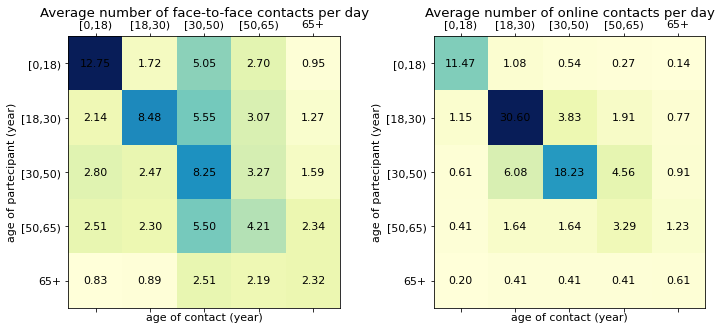

In [ ]:
# model parameters

R_0 = 2.5 #1.0 critical
mu = 1/10
#beta_F = np.array([1.5, 1.5, 1.5, 1.5, 1.5]) #20/7 critical
beta_F = np.array([0.05, 0.1, 0.12, 0.16, 0.2]) #20/7 critical

mu_F = 1/5
#mu_F = 1/7
r_b = 0.3
alpha = 0.05
gamma = 0.7

R0 = [0, 0, 0, 0, 0]                  # initially recovered
S_F0 = [0, 0, 0, 0, 0]                # initially feared
I0 = [0, 0, 1, 0, 0]                  # initially infected

N_tot = 60*10**6                      # Italian population
T = 1000                              # simulation time
T_switch = 50

classes = np.array([0.092, 0.149, 0.372, 0.185, 0.202]) # population Italy 2008
N_classes = N_tot*classes

#face-to-face contact matrix
k = np.loadtxt(open("socrates_social_contact_matrix.csv", "rb"), delimiter=",", skiprows=1)

#online contact matrix
M = np.loadtxt(open("online_contact_matrix.csv", "rb"), delimiter=",", skiprows=1)


#Plot
figure, axis = plt.subplots(1, 2, figsize=(12, 5))
lab = ['[0,18)', '[18,30)', '[30,50)', '[50,65)', '65+']

cax0 = axis[0].matshow(k, cmap='YlGnBu')
axis[0].set_title('Average number of face-to-face contacts per day')
axis[0].set_xlabel('age of contact (year)')
axis[0].set_ylabel('age of partecipant (year)')
axis[0].set_xticklabels(['']+lab)
axis[0].set_yticklabels(['']+lab)
for (i, j), z in np.ndenumerate(k):
    axis[0].text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

cax1 = axis[1].matshow(M, cmap='YlGnBu')
axis[1].set_title('Average number of online contacts per day')
axis[1].set_xlabel('age of contact (year)')
axis[1].set_ylabel('age of partecipant (year)')
axis[1].set_xticklabels(['']+lab)
axis[1].set_yticklabels(['']+lab)
for (i, j), z in np.ndenumerate(M):
    axis[1].text(j, i, '{:0.2f}'.format(z), ha='center', va='center')

In [ ]:
flag = 1
mod = 1
time, S, S_F, I, R, r_inf = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod, flag)

Text(0.5, 1.0, '$r (t)$')

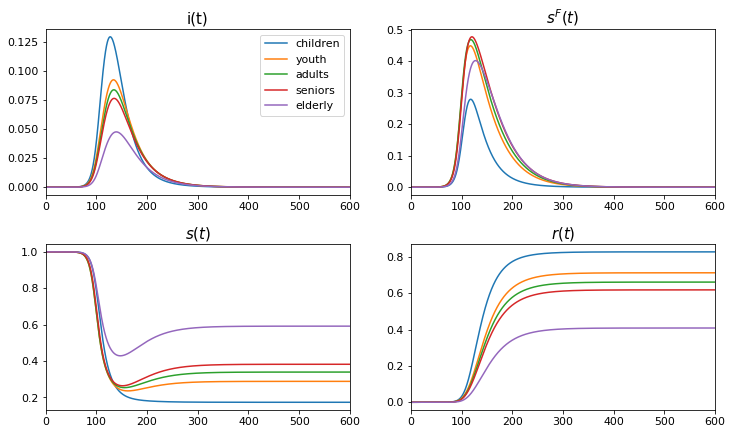

In [ ]:
figure, axis = plt.subplots(2, 2)
plt.setp(axis, xlim=[0,600])
plt.subplots_adjust(hspace=0.3)

axis[0,0].plot(time,I[0]/N_classes[0], label='children')
axis[0,0].plot(time,I[1]/N_classes[1], label='youth')
axis[0,0].plot(time,I[2]/N_classes[2], label='adults')
axis[0,0].plot(time,I[3]/N_classes[3], label='seniors')
axis[0,0].plot(time,I[4]/N_classes[4], label='elderly')
axis[0,0].set_title("i(t)", fontsize = 15)
#axis[0,0].vlines(T_switch, 0, np.max(I[1]/N_classes[1]), colors = 'r', linestyles = 'dashed')
axis[0,0].legend()

axis[0,1].plot(time,S_F[0]/N_classes[0], label='children')
axis[0,1].plot(time,S_F[1]/N_classes[1], label='youth')
axis[0,1].plot(time,S_F[2]/N_classes[2], label='adults')
axis[0,1].plot(time,S_F[3]/N_classes[3], label='seniors')
axis[0,1].plot(time,S_F[4]/N_classes[4], label='elderly')
axis[0,1].set_title(r"$s^F (t)$", fontsize = 15)
#axis[0,1].vlines(T_switch, 0, np.max(S_F[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')

axis[1,0].plot(time,S[0]/N_classes[0], label='children')
axis[1,0].plot(time,S[1]/N_classes[1], label='youth')
axis[1,0].plot(time,S[2]/N_classes[2], label='adults')
axis[1,0].plot(time,S[3]/N_classes[3], label='seniors')
axis[1,0].plot(time,S[4]/N_classes[4], label='elderly')
axis[1,0].set_title(r"$s (t)$", fontsize = 15)
#axis[1,0].vlines(T_switch, 0, np.max(S[0]/N_classes[0]), colors = 'r', linestyles = 'dashed')

axis[1,1].plot(time,R[0]/N_classes[0], label='children')
axis[1,1].plot(time,R[1]/N_classes[1], label='youth')
axis[1,1].plot(time,R[2]/N_classes[2], label='adults')
axis[1,1].plot(time,R[3]/N_classes[3], label='seniors')
axis[1,1].plot(time,R[4]/N_classes[4], label='elderly')
axis[1,1].set_title(r"$r (t)$", fontsize = 15)
#axis[1,1].vlines(T_switch, 0, np.max(R[1]/N_classes[1]), colors = 'r', linestyles = 'dashed')

### 1. Online sensibilization campaign

In [ ]:
flag = 2
T = 2000
mod_ = np.linspace(1, 4, 50)
zr = np.zeros((50, 5))
h_peak = np.zeros((50,5))
time_ext = np.zeros((50,5))

for i in tqdm(range(mod_.shape[0])):
    row = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod_[i], flag)
    zr[i] = row[5]

    for j in range(5):
        time_ext[i, j] = find_end(row[3][j])
        h_peak[i, j] = max(find_peaks(row[3][j]/N_classes[j], height= 0)[1]['peak_heights'])

mod_2 = mod_
zr2 = zr
h_peak2 = h_peak
time_ext2 = time_ext

100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


### 2. Isolating elderly people

In [ ]:
flag = 3
T = 2000
mod_ = np.linspace(0.01, 1, 50)
zr = np.zeros((50, 5))
h_peak = np.zeros((50,5))
time_ext = np.zeros((50,5))

for i in tqdm(range(mod_.shape[0])):
    row = deterministic_simulation(R_0, beta_F, r_b, mu, mu_F, alpha, gamma, R0, S_F0, I0, N_classes, T, k, M, T_switch, mod_[i], flag)
    zr[i] = row[5]

    for j in range(5):
        time_ext[i, j] = find_end(row[3][j])
        h_peak[i, j] = max(find_peaks(row[3][j]/N_classes[j], height= 0)[1]['peak_heights'])

mod_3 = mod_
zr3 = zr
h_peak3 = h_peak
time_ext3 = time_ext
perc_ = 100-mod_*100

100%|██████████| 50/50 [01:37<00:00,  1.96s/it]


## Results

Text(0.5, 0, 'percentage of contact reduction')

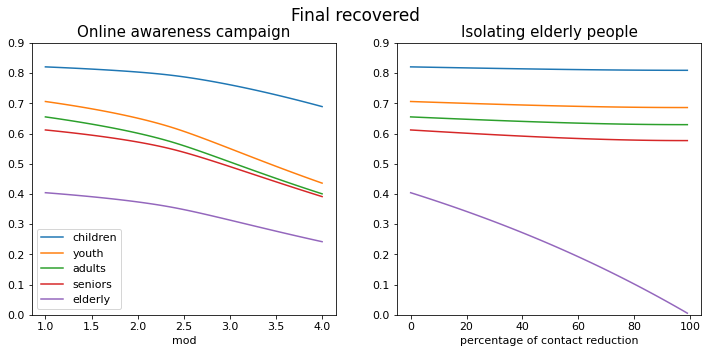

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Final recovered", fontsize = 17)
plt.setp(axis, ylim=[0,0.9])

axis[0].plot(mod_2, zr2[:,0], label='children')
axis[0].plot(mod_2, zr2[:,1], label='youth')
axis[0].plot(mod_2, zr2[:,2], label='adults')
axis[0].plot(mod_2, zr2[:,3], label='seniors')
axis[0].plot(mod_2, zr2[:,4], label='elderly')
axis[0].set_title('Online awareness campaign', fontsize = 15)
axis[0].set_xlabel("mod")
axis[0].legend()

axis[1].plot(perc_, zr3[:,0], label='children')
axis[1].plot(perc_, zr3[:,1], label='youth')
axis[1].plot(perc_, zr3[:,2], label='adults')
axis[1].plot(perc_, zr3[:,3], label='seniors')
axis[1].plot(perc_, zr3[:,4], label='elderly')
axis[1].set_title('Isolating elderly people', fontsize = 15)
axis[1].set_xlabel("percentage of contact reduction")

Text(0.5, 0, 'percentage of contact reduction')

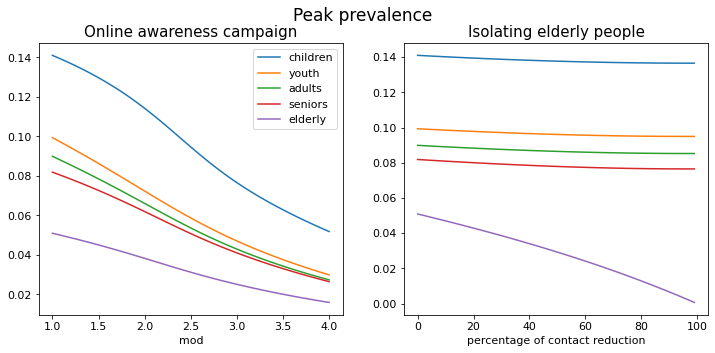

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Peak prevalence", fontsize = 17)
#plt.setp(axis, ylim=[0,0.12])

axis[0].plot(mod_2, h_peak2[:,0], label='children')
axis[0].plot(mod_2, h_peak2[:,1], label='youth')
axis[0].plot(mod_2, h_peak2[:,2], label='adults')
axis[0].plot(mod_2, h_peak2[:,3], label='seniors')
axis[0].plot(mod_2, h_peak2[:,4], label='elderly')
axis[0].set_title('Online awareness campaign', fontsize = 15)
axis[0].set_xlabel("mod")
axis[0].legend()

axis[1].plot(perc_, h_peak3[:,0], label='children')
axis[1].plot(perc_, h_peak3[:,1], label='youth')
axis[1].plot(perc_, h_peak3[:,2], label='adults')
axis[1].plot(perc_, h_peak3[:,3], label='seniors')
axis[1].plot(perc_, h_peak3[:,4], label='elderly')
axis[1].set_title('Isolating elderly people', fontsize = 15)
axis[1].set_xlabel("percentage of contact reduction")

Text(0.5, 0, 'percentage of contact reduction')

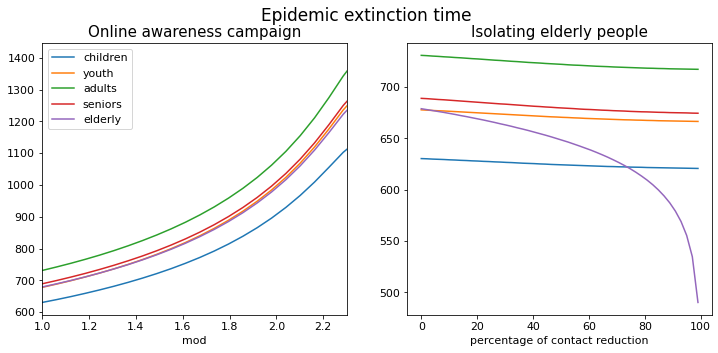

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle("Epidemic extinction time", fontsize = 17)

axis[0].plot(mod_2, time_ext2[:,0], label='children')
axis[0].plot(mod_2, time_ext2[:,1], label='youth')
axis[0].plot(mod_2, time_ext2[:,2], label='adults')
axis[0].plot(mod_2, time_ext2[:,3], label='seniors')
axis[0].plot(mod_2, time_ext2[:,4], label='elderly')
axis[0].set_title('Online awareness campaign', fontsize = 15)
axis[0].set_xlabel("mod")
axis[0].set_xlim(1,2.3)
axis[0].legend()

axis[1].plot(perc_, time_ext3[:,0], label='children')
axis[1].plot(perc_, time_ext3[:,1], label='youth')
axis[1].plot(perc_, time_ext3[:,2], label='adults')
axis[1].plot(perc_, time_ext3[:,3], label='seniors')
axis[1].plot(perc_, time_ext3[:,4], label='elderly')
axis[1].set_title('Isolating elderly people', fontsize = 15)
#axis[1].set_ylim(500,850)
axis[1].set_xlabel("percentage of contact reduction")